In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from lcls_beamline_toolbox.models import mfx_gpu
from lcls_beamline_toolbox.xraybeamline2d import beam

Can't find epics package. PPM_Imager class will not be supported


In [2]:
# first argument is photon energy, N is a sampling parameter. 
# The wavefront propagation happens on a NxN grid - will affect the resolution of the result.
# Using a GPU will help a lot for N>~256

mfx_sim = mfx_gpu.MFX(9500,N=512)

# ax and/or ay arguments for undulator pointing. These are in units of radians, and based on my understanding, the pivot point of the rotation is about
# the upstream end of the undulators about 100m upstream of the undulator exit.
# mfx_sim.undulator_pointing(ax=1e-6,ay=1e-6)

FWHM in x: 50.063160108007565 microns
FWHM in y: 50.063160108007565 microns
FWHM Divergence (x): 1.6 μrad
FWHM Divergence (y): 1.6 μrad
x is focused
y is focused


In [3]:
# random misalignment of all the transfocator lenses
for i in range(9):
    getattr(mfx_sim,'tfs_{}_x'.format(i+2)).mvr(2*(np.random.rand(1)-0.5)*50e-6)
    getattr(mfx_sim,'tfs_{}_y'.format(i+2)).mvr(2*(np.random.rand(1)-0.5)*50e-6)

# set limits
mfx_sim.tfs_z.set_low_limit(-.5)
mfx_sim.tfs_z.set_high_limit(.5)

# test limit
# mfx_sim.tfs_z.mv(0.6)
# # still zero since it doesn't move outside limit
# print(mfx_sim.tfs_z.wm())

# # move within limits (relative move)
# mfx_sim.tfs_z.mvr(.1)
# print(mfx_sim.tfs_z.wm())

In [5]:
# check which crls are in use
for num, crl in enumerate(mfx_sim.tfs_list):
    # if num>5:
    #     crl.enable()
    # else:
    #     crl.disable()
    print('crl {} ({}um ROC) inserted: {}'.format(crl.name,crl.roc*1e6,crl.enabled))

crl tfs_2 (500.0um ROC) inserted: True
crl tfs_3 (300.0um ROC) inserted: False
crl tfs_4 (250.0um ROC) inserted: False
crl tfs_5 (200.0um ROC) inserted: False
crl tfs_6 (125.0um ROC) inserted: True
crl tfs_7 (62.5um ROC) inserted: False
crl tfs_8 (50.0um ROC) inserted: False
crl tfs_9 (50.0um ROC) inserted: True
crl tfs_10 (50.0um ROC) inserted: False


In [5]:
# run the simulation
mfx_sim.propagate()

FWHM in x: 186.37886288769366 microns
FWHM in y: 186.37886288769366 microns
FWHM Divergence (x): 1.6 μrad
FWHM Divergence (y): 1.6 μrad
x is focused
y is focused
IM2L0
IM2L0 took 0.002857917000000043 seconds
zx: 111.990000
zy: 111.990000
azimuth 0.00 mrad
drift1
global_x 0.00
global_y 0.00
x intersect: 0.0000e+00
component x: 0.0000e+00
y intersect: 0.0000e+00
component y: 0.0000e+00
z intersect: 7.4000e+02
component z: 7.4000e+02
delta z: 0.00
zRx: 311193370.52 microns
zRy: 311193370.52 microns
remaining distance: 4010000.00 microns
goal for zx: 116000000.00 microns
current zx: 111990000.00 microns
goal for zy: 116000000.00 microns
current zy: 111990000.00 microns
drift1 took 0.01788025000000104 seconds
zx: 116.000000
zy: 116.000000
azimuth 0.00 mrad
MR1L0
shape sum: 0.0
MR1L0 took 0.012236916999999181 seconds
zx: 116.000000
zy: 116.000000
azimuth 4.20 mrad
drift2
global_x 0.00
global_y 0.00
x intersect: 2.5200e-02
component x: 2.5200e-02
y intersect: 0.0000e+00
component y: 0.0000e+0

[<Axes: title={'center': 'DG3_YAG'}, xlabel='X coordinates (microns)', ylabel='Y coordinates (microns)'>,
 <Axes: >,
 <Axes: >]

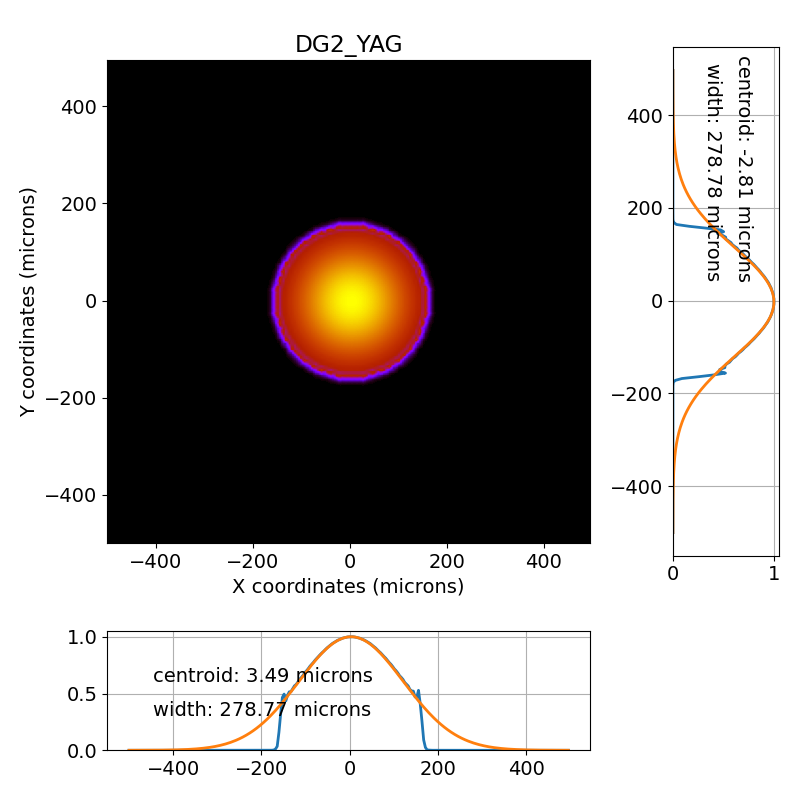

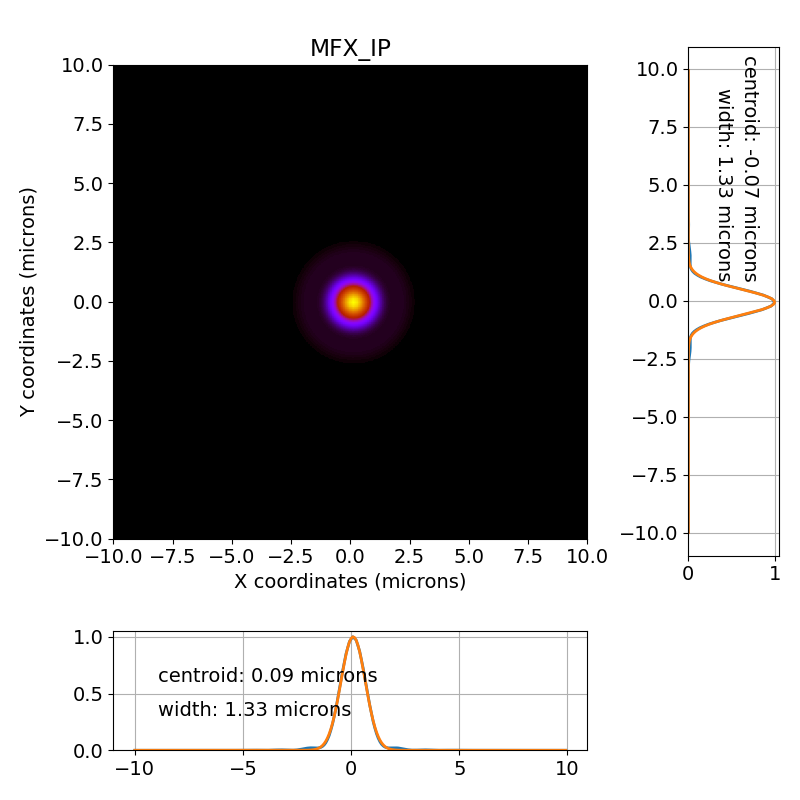

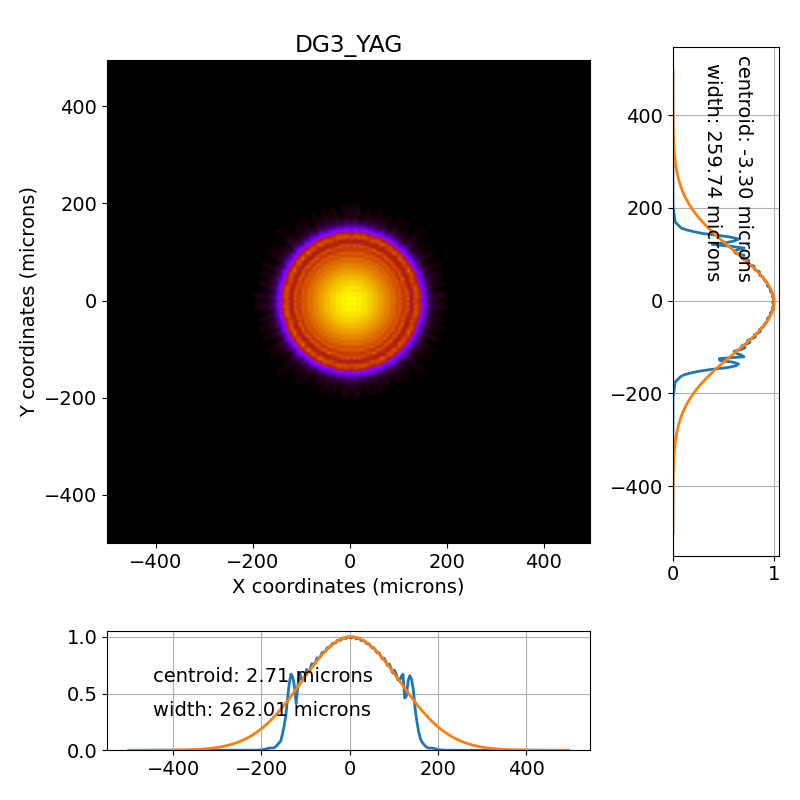

In [6]:
# display results
mfx_sim.beamline.DG2_YAG.view_beam()
mfx_sim.beamline.MFX_IP.view_beam()
mfx_sim.beamline.DG3_YAG.view_beam()

In [9]:
import time

In [10]:
beam_params = {
            'photonEnergy': 9500,
            'N': 512,
            'sigma_x': 30e-6,
            'sigma_y': 30e-6,
            'rangeFactor': 5,
            'scaleFactor': 10,
            'z_source': 650 - 26
        }

pulse_test = beam.Pulse(beam_params=beam_params, tau=.05, time_window=.5)

start = time.time()

pulse_test.propagate(beamline=mfx_sim.beamline, screen_names=['DG2_YAG','MFX_IP','DG3_YAG'],cores=8)

end = time.time()

Can't find epics package. PPM_Imager class will not be supported
Can't find epics package. PPM_Imager class will not be supported
Can't find epics package. PPM_Imager class will not be supported
Can't find epics package. PPM_Imager class will not be supported
Can't find epics package. PPM_Imager class will not be supported
Can't find epics package. PPM_Imager class will not be supported
Can't find epics package. PPM_Imager class will not be supported
Can't find epics package. PPM_Imager class will not be supported


In [11]:
print(end-start)

302.4141991138458


(256, 256, 22)
[9407.00344678 9415.86026137 9424.71707597 9433.57389056 9442.43070515
 9451.28751974 9460.14433433 9469.00114893 9477.85796352 9486.71477811
 9495.5715927  9504.4284073  9513.28522189 9522.14203648 9530.99885107
 9539.85566567 9548.71248026 9557.56929485 9566.42610944 9575.28292403
 9584.13973863 9592.99655322]


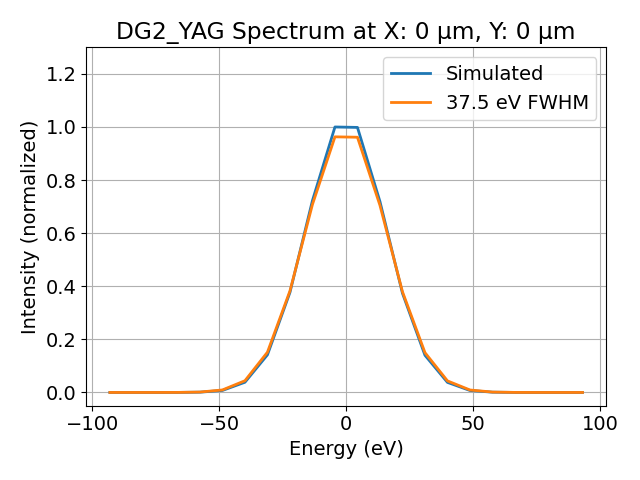

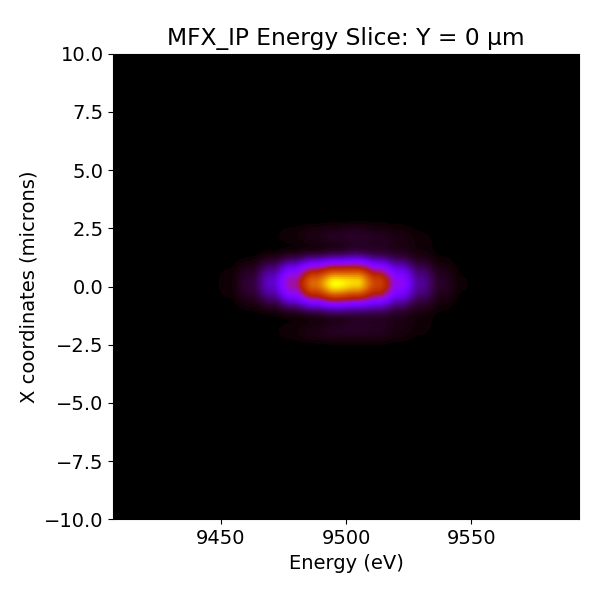

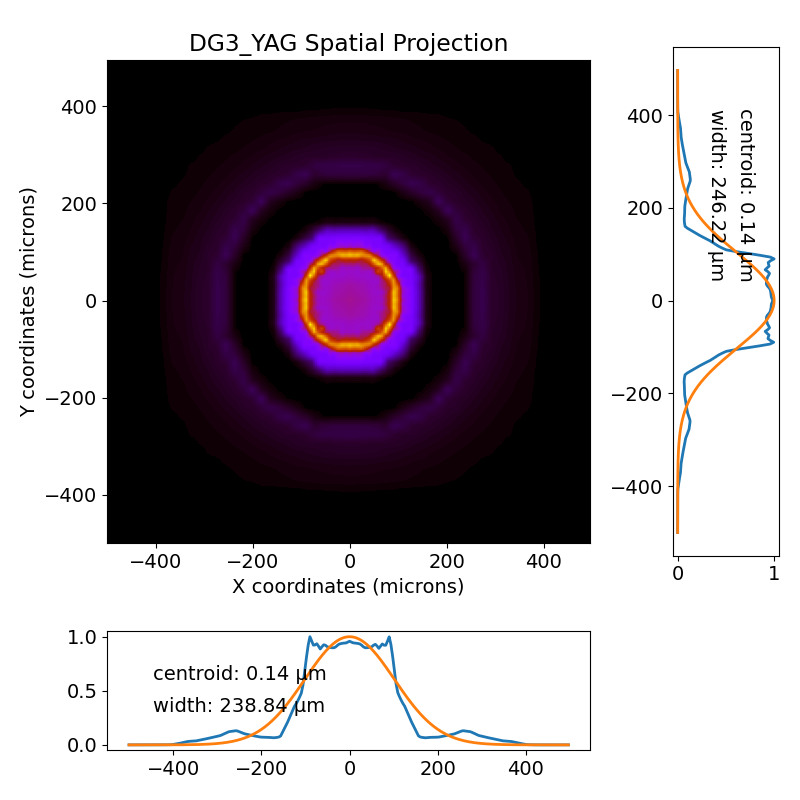

In [14]:
pulse_test.plot_spectrum('DG2_YAG')
pulse_test.imshow_energy_slice('MFX_IP')
pulse_test.imshow_projection('DG3_YAG')
print(np.shape(pulse_test.energy_stacks['DG2_YAG']))
print(pulse_test.energy)

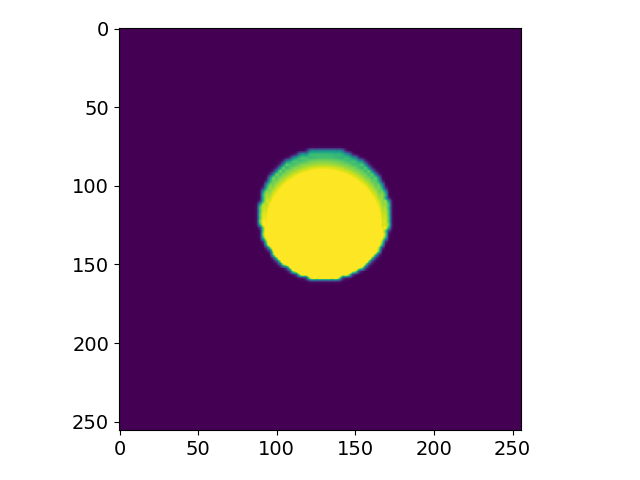

In [8]:
# access to the image array
ip_array = mfx_sim.beamline.DG2_YAG.profile
plt.figure()
plt.imshow(ip_array)
plt.clim(0,.1)